<a href="https://colab.research.google.com/github/GabrielBrionesL/liferay_sales_data_analysis/blob/main/Sales_Data_Analysis_Liferay_Gabriel_Briones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sales Data Analysis - Liferay - Gabriel Briones



This notebook serves to analyze a sales dataset to extract key business insights, identify trends, and build a predictive scoring model. The primary objective is to understand the sales process, customer lifecycle, and revenue generation to inform business strategy.

In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score

## 1. Business Objective and Data Understanding

Before we explore the data, it's crucial to understand the business context. The primary goal is to analyze sales opportunities to gain insights into the sales process, customer lifecycle, and revenue generation. We need to understand what an 'opportunity' means within the cxontext of the data and how its status changes reflect real-world sales activities.

## 2. Data Ingestion

Now that the business objective is clear, the next step is to bring the data in for exploration and analysis.

In [183]:
# Load the CSV into a pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Liferay/sales_data.csv")

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   company                   5656 non-null   object
 1   opportunity_value         5656 non-null   int64 
 2   old_status_label          5656 non-null   object
 3   new_status_label          5656 non-null   object
 4   status_change_date        5656 non-null   int64 
 5   lead_created_date         5656 non-null   int64 
 6   current_lead_status       5656 non-null   object
 7   current_lead_status_date  5656 non-null   object
 8   current_opp_status        5656 non-null   object
 9   current_opp_status_date   5656 non-null   int64 
 10  billing_period_unit       5656 non-null   object
 11  billing_period            5656 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 530.4+ KB


In [185]:
df.describe()

,opportunity_value,status_change_date,lead_created_date,current_opp_status_date,billing_period
count,5656.000000,5.656000e+03,5.656000e+03,5.656000e+03,5656.000000
mean,141.966407,1.532416e+09,1.526617e+09,1.534909e+09,3.355552
std,172.190700,2.265284e+07,2.413869e+07,2.243511e+07,3.210008
min,4.000000,1.458755e+09,1.455129e+09,1.465314e+09,1.000000
25%,40.000000,1.520578e+09,1.512052e+09,1.522773e+09,1.000000
50%,79.000000,1.539871e+09,1.533815e+09,1.543397e+09,1.000000
75%,167.000000,1.550154e+09,1.545130e+09,1.552057e+09,6.000000
max,1794.000000,1.557924e+09,1.557845e+09,1.557924e+09,11.000000


In [186]:
# Check for outliers for opportunity value
df[df["opportunity_value"] <= 0]
df[df["opportunity_value"] > df["opportunity_value"].quantile(0.99)]
df[df["opportunity_value"] > df["opportunity_value"].quantile(0.99)].sort_values("opportunity_value", ascending=False).head(10)

,company,opportunity_value,old_status_label,new_status_label,status_change_date,lead_created_date,current_lead_status,current_lead_status_date,current_opp_status,current_opp_status_date,billing_period_unit,billing_period
1868,company1879,1794,MR - Qualification,AE - Qualified,1557473273,1555487359,Qualified,2019-05-10 14:30:00,AE - Qualified,1557473273,year,1
1786,company1797,1657,MR - Qualification,Opp - Lost,1554727123,1553615792,Disqualified,2019-04-08 12:38:54,Opp - Lost,1554727123,year,1
4523,company4534,1649,SD - Interested,SD - Engaged,1555407358,1553509276,Pre-qualified Outbound,2019-04-16 9:34:45,SD - Engaged,1555407358,year,1
13,company24,1619,SD - Interested,SD - Engaged,1552470035,1551269340,Pre-qualified Outbound,2019-03-13 9:40:38,SD - Engaged,1552470035,year,1
4507,company4518,1502,MR - Qualification,AE - Qualified,1551276608,1550827207,Customer,2019-04-30 17:30:56,Confirmed,1556645509,year,1
4508,company4518,1502,AE - Qualified,Confirmed,1556645509,1550827207,Customer,2019-04-30 17:30:56,Confirmed,1556645509,year,1
419,company430,1491,SD - Interested,Opp - Lost,1556802677,1554391814,Not Interested,2019-05-02 13:10:56,Opp - Lost,1556802677,year,1
4527,company4538,1469,SD - Engaged,Opp - Lost,1557915808,1554901174,Lost,2019-05-15 10:23:35,Opp - Lost,1557915808,year,1
768,company779,1408,MR - Qualification,Opp - Lost,1553770689,1551350579,Disqualified,2019-03-28 10:58:02,Opp - Lost,1553770689,year,1
386,company397,1313,MR - Qualification,AE - Qualified,1550076500,1548838592,Lost,2019-05-02 14:22:18,Opp - Lost,1556806945,year,1


In [187]:
df.head(10)

,company,opportunity_value,old_status_label,new_status_label,status_change_date,lead_created_date,current_lead_status,current_lead_status_date,current_opp_status,current_opp_status_date,billing_period_unit,billing_period
0,company11,29,MR - Qualification,AE - Qualified,1539012820,1538999275,Customer,2018-10-10 14:47:41,Paying,1539865532,month,1
1,company11,29,AE - Qualified,AE - Negotiation,1539014349,1538999275,Customer,2018-10-10 14:47:41,Paying,1539865532,month,1
2,company11,29,AE - Negotiation,Confirmed,1539182857,1538999275,Customer,2018-10-10 14:47:41,Paying,1539865532,month,1
3,company11,29,Confirmed,Paying,1539865532,1538999275,Customer,2018-10-10 14:47:41,Paying,1539865532,month,3
4,company15,272,MR - Qualification,AE - Qualified,1554296386,1554112481,Qualified,2019-04-03 12:57:49,AE - Qualified,1554296386,year,1
5,company16,337,SD - Engaged,AE - Qualified,1551697514,1551105566,Qualified,2019-03-04 11:04:42,AE - Qualified,1551697514,year,1
6,company17,800,MR - Qualification,SD - Interested,1539586875,1539161457,Qualified,2019-05-14 17:12:54,AE - Qualified,1557854149,year,1
7,company17,800,SD - Interested,SD - Engaged,1554715218,1539161457,Qualified,2019-05-14 17:12:54,AE - Qualified,1557854149,year,1
8,company17,800,SD - Engaged,AE - Qualified,1557854149,1539161457,Qualified,2019-05-14 17:12:54,AE - Qualified,1557854149,year,1
9,company20,266,SD - Interested,SD - Engaged,1550584054,1550500114,Qualified,2019-02-21 9:30:51,AE - Qualified,1550741441,year,1


We used `df.info()` to understand data types and identify any missing values. We used `df.describe()` to get a statistical summary of numerical columns. These steps help us assess data quality and help drive further data cleaning and transformation.

## 3. Data Quality

In [188]:
# Check for missing values
df.isnull().sum()

,0
company,0
opportunity_value,0
old_status_label,0
new_status_label,0
status_change_date,0
lead_created_date,0
current_lead_status,0
current_lead_status_date,0
current_opp_status,0
current_opp_status_date,0


In [189]:
# Check unique value counts
df.nunique()

,0
company,3052
opportunity_value,426
old_status_label,11
new_status_label,11
status_change_date,5647
lead_created_date,3070
current_lead_status,19
current_lead_status_date,3049
current_opp_status,10
current_opp_status_date,3063


In [190]:
# Look at value distributions for columns
for col in ['new_status_label', 'old_status_label', 'billing_period_unit', 'current_lead_status', 'current_opp_status']:
    print(f"\n{col}:\n", df[col].value_counts())


new_status_label:
 new_status_label
Opp - Lost              1458
AE - Qualified          1320
Confirmed               1136
Paying                  1014
SD - Engaged             246
AE - Solution Design     225
AE - Negotiation         145
MR - Qualification        72
Won                       22
SD - Interested           13
Churned                    5
Name: count, dtype: int64

old_status_label:
 old_status_label
AE - Qualified          2284
MR - Qualification      1055
Confirmed                959
SD - Interested          478
SD - Engaged             327
AE - Solution Design     196
Opp - Lost               174
AE - Negotiation         140
Won                       32
Paying                    10
Churned                    1
Name: count, dtype: int64

billing_period_unit:
 billing_period_unit
year     2972
month    2684
Name: count, dtype: int64

current_lead_status:
 current_lead_status
Customer                  2983
Lost                      1197
Qualified                  687
Dis

We can see from a high-level overview of the data that we need to:

*   Convert timestamps into readable datetime formats
*   Understand the meaning of `old_status_label` and `new_status_label` to understand how opportunities are progressing through the sales pipeline.
*   Understand how `opportunity_value`, `billing_period_unit` and `billing_period` affect revenue to accurately calculate Monthly Recurring Revenue (MRR).

It is also evident at a first glance that we:

*   There are no duplicate rows
*   No missing values
*   Naming conventions are consistent within the column, so cleaning won't need to take place for columns such as `current_lead_status` and `current_opp_status`, just to name a few.






## 4. Data Transformation

Raw data generally needs to be cleaned and preprocessed in order to be useable for analysis. For this dataset, the most important preprocessing step is converting Unix timestamps into readable datetime objects.

In [191]:
# Convert timestamps to datetime
df['status_change_date'] = pd.to_datetime(df['status_change_date'], unit='s')
df['lead_created_date'] = pd.to_datetime(df['lead_created_date'], unit='s')
df['current_opp_status_date'] = pd.to_datetime(df['current_opp_status_date'], unit='s')

In [192]:
df.head(10)

,company,opportunity_value,old_status_label,new_status_label,status_change_date,lead_created_date,current_lead_status,current_lead_status_date,current_opp_status,current_opp_status_date,billing_period_unit,billing_period
0,company11,29,MR - Qualification,AE - Qualified,2018-10-08 15:33:40,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1
1,company11,29,AE - Qualified,AE - Negotiation,2018-10-08 15:59:09,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1
2,company11,29,AE - Negotiation,Confirmed,2018-10-10 14:47:37,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1
3,company11,29,Confirmed,Paying,2018-10-18 12:25:32,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,3
4,company15,272,MR - Qualification,AE - Qualified,2019-04-03 12:59:46,2019-04-01 09:54:41,Qualified,2019-04-03 12:57:49,AE - Qualified,2019-04-03 12:59:46,year,1
5,company16,337,SD - Engaged,AE - Qualified,2019-03-04 11:05:14,2019-02-25 14:39:26,Qualified,2019-03-04 11:04:42,AE - Qualified,2019-03-04 11:05:14,year,1
6,company17,800,MR - Qualification,SD - Interested,2018-10-15 07:01:15,2018-10-10 08:50:57,Qualified,2019-05-14 17:12:54,AE - Qualified,2019-05-14 17:15:49,year,1
7,company17,800,SD - Interested,SD - Engaged,2019-04-08 09:20:18,2018-10-10 08:50:57,Qualified,2019-05-14 17:12:54,AE - Qualified,2019-05-14 17:15:49,year,1
8,company17,800,SD - Engaged,AE - Qualified,2019-05-14 17:15:49,2018-10-10 08:50:57,Qualified,2019-05-14 17:12:54,AE - Qualified,2019-05-14 17:15:49,year,1
9,company20,266,SD - Interested,SD - Engaged,2019-02-19 13:47:34,2019-02-18 14:28:34,Qualified,2019-02-21 9:30:51,AE - Qualified,2019-02-21 09:30:41,year,1


In [193]:
# Earliest and latest dates
df[["lead_created_date", "status_change_date", "current_opp_status_date"]].agg(["min", "max"])

,lead_created_date,status_change_date,current_opp_status_date
min,2016-02-10 18:28:16,2016-03-23 17:50:27,2016-06-07 15:42:02
max,2019-05-14 14:37:44,2019-05-15 12:35:03,2019-05-15 12:35:03


In [194]:
# Checking for negative or zero durations
df["lead_to_status_days"] = (df["status_change_date"] - df["lead_created_date"]).dt.days
df[df["lead_to_status_days"] < 0]

,company,opportunity_value,old_status_label,new_status_label,status_change_date,lead_created_date,current_lead_status,current_lead_status_date,current_opp_status,current_opp_status_date,billing_period_unit,billing_period,lead_to_status_days


Now that the data is transformed, let's load the data to a SQLite database to be able to query our data.

In [195]:
# Connect to SQLite database
db_path = "/content/drive/MyDrive/Colab Notebooks/Liferay/sales_data.db"
conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/Liferay/sales_data.db")

In [196]:
# Upload dataframe to SQLite
df.to_sql("sales_opps", conn, if_exists="replace", index=False)

5656

In [197]:
# Verify data loaded successfully by pulling sample
query_sample = "SELECT * FROM sales_opps LIMIT 5;"
sample_df = pd.read_sql_query(query_sample, conn)
print("Sample Data from SQLite:")
print(sample_df)

Sample Data from SQLite:
     company  opportunity_value    old_status_label  new_status_label  \
0  company11                 29  MR - Qualification    AE - Qualified   
1  company11                 29      AE - Qualified  AE - Negotiation   
2  company11                 29    AE - Negotiation         Confirmed   
3  company11                 29           Confirmed            Paying   
4  company15                272  MR - Qualification    AE - Qualified   

    status_change_date    lead_created_date current_lead_status  \
0  2018-10-08 15:33:40  2018-10-08 11:47:55            Customer   
1  2018-10-08 15:59:09  2018-10-08 11:47:55            Customer   
2  2018-10-10 14:47:37  2018-10-08 11:47:55            Customer   
3  2018-10-18 12:25:32  2018-10-08 11:47:55            Customer   
4  2019-04-03 12:59:46  2019-04-01 09:54:41           Qualified   

  current_lead_status_date current_opp_status current_opp_status_date  \
0      2018-10-10 14:47:41             Paying     2018-10-18

## 4. SQL Queries for Key Business Metrics

We will execute the SQL queries that answer specific business questions:

* Calculate the average time per company to become a customer
* Calculate how many customers have churned and reactivated
* Calculate the expected MRR (monthly recurring revenue) per month  
* Calculate the number of (potential) customers per month up to today




### Average Time per Company to Become a Customer

We need to calculate the average time it takes for a company to switch from `lead_created_date` to having a `new_status_label` listed as 'Paying', with the assumption that 'Paying' means you have become a customer. From here, we can subtract the `lead_created_date` from the `status_change_date` when company becomes 'Paying', we are able to track the sales cycle per company in days.

In [198]:
query_days_to_customer_per_company = """
WITH CustomerStatus AS (
    SELECT
        company,
        MIN(status_change_date) AS first_paying_date
    FROM sales_opps
    WHERE new_status_label = 'Paying'
    GROUP BY company
),
LeadDates AS (
    SELECT
        company,
        MIN(lead_created_date) AS first_lead_date
    FROM sales_opps
    GROUP BY company
)
SELECT
    c.company,
    ROUND(JULIANDAY(c.first_paying_date) - JULIANDAY(l.first_lead_date), 2) AS days_to_customer
FROM CustomerStatus c
JOIN LeadDates l ON c.company = l.company;
"""

In [199]:
company_days_df = pd.read_sql_query(query_days_to_customer_per_company, conn)
print(company_days_df)

          company  days_to_customer
0     company1002              9.66
1      company101             61.24
2     company1016             35.22
3     company1023             75.29
4     company1031             35.70
...           ...               ...
1003   company967             74.13
1004   company971            289.07
1005   company980             26.21
1006   company986              4.07
1007   company996             42.06

[1008 rows x 2 columns]


### Churned and Reactivated Customers

We want to identify churned and reactivated customers by tracking status changes for each company. A company is considered 'churned' if it transitions from 'Paying' to any other status. A company is 'reactivated' if it transitions back to 'Paying' after having previously churned. We will use a window function and then aggregate monthly to understand customer retention trends over time.

In [200]:
query_status_changes = """
WITH StatusTransitions AS (
    SELECT
        company,
        strftime('%Y-%m', status_change_date) AS Month,
        LAG(new_status_label) OVER (
            PARTITION BY company ORDER BY status_change_date
        ) AS prev_status,
        new_status_label
    FROM sales_opps
    WHERE status_change_date IS NOT NULL
),

ChurnEvents AS (
    SELECT
        Month,
        company,
        CASE
            WHEN prev_status = 'Paying' AND new_status_label != 'Paying' THEN 1 ELSE 0 END AS churned,
        CASE
            WHEN prev_status != 'Paying' AND new_status_label = 'Paying' THEN 1 ELSE 0 END AS reactivated
    FROM StatusTransitions
)

SELECT
    Month,
    COUNT(DISTINCT CASE WHEN churned = 1 THEN company END) AS churned_customers,
    COUNT(DISTINCT CASE WHEN reactivated = 1 THEN company END) AS reactivated_customers
FROM ChurnEvents
GROUP BY Month
ORDER BY Month;
"""

In [201]:
status_changes_df = pd.read_sql_query(query_status_changes, conn)
print(status_changes_df)

      Month  churned_customers  reactivated_customers
0   2016-03                  0                      0
1   2016-04                  0                      0
2   2016-05                  0                      0
3   2016-06                  0                     20
4   2016-07                  0                      0
5   2016-08                  0                      0
6   2016-09                  0                      2
7   2016-10                  0                      2
8   2016-11                  0                      6
9   2016-12                  0                      1
10  2017-01                  0                     69
11  2017-02                  0                     14
12  2017-03                  0                     31
13  2017-04                  0                     14
14  2017-05                  0                     35
15  2017-06                  0                     22
16  2017-07                  0                     27
17  2017-08                 

We also want to see if there's any churned and reactivated together to identify re-engagement

In [202]:
query_churn_and_react= """
SELECT COUNT(DISTINCT s1.company) AS churned_and_reactivated_companies
FROM sales_opps s1
JOIN sales_opps s2
  ON s1.company = s2.company
 AND s1.status_change_date < s2.status_change_date
WHERE s1.new_status_label = 'Churned'
  AND s2.new_status_label = 'Paying';
"""

In [203]:
churn_and_react_df = pd.read_sql_query(query_churn_and_react, conn)
print(churn_and_react_df)

   churned_and_reactivated_companies
0                                  2


There's only 2.

### Expected MMR per Month

We need to calculate the expected Monthly Recurring Revenue (MRR) by aggregating `opportunity_value` for opportunities with a `new_status_label` of 'Paying'.

We are assuming the `opportunity_value` is on a monthly basis, dividing by 12 if the `billing_period_unit` is 'year', and taking the value directly if it's 'month'.

In [204]:
query_mrr = """
SELECT
    strftime('%Y-%m', status_change_date) AS Month,
    SUM(
        CASE
            WHEN new_status_label = 'Paying' AND billing_period_unit = 'month' THEN opportunity_value
            WHEN new_status_label = 'Paying' AND billing_period_unit = 'year' THEN opportunity_value / 12.0
            ELSE 0
        END
    ) AS Expected_MRR
FROM
    sales_opps
WHERE
    new_status_label = 'Paying'
    AND status_change_date IS NOT NULL
GROUP BY
    Month
ORDER BY
    Month;
"""

In [205]:
mrr_df = pd.read_sql_query(query_mrr, conn)
print(mrr_df.head(5))

     Month  Expected_MRR
0  2016-06    887.666667
1  2016-07     95.000000
2  2016-08     91.000000
3  2016-09    110.000000
4  2016-10     69.500000


### Number of Potential Customers per Month

We need to count the number of unique companies that have an active status based on their `lead_created_date`. We saw the value count earlier and know that an active status includes: 'Paying', 'AE - Qualified', 'AE - Solution Design', 'MR - Qualification', 'SD - Engaged', 'SD - Interested', 'Confirmed', 'Customer'. We are able to visualize our sales funnel by counting and summing these new potential customers per month.

In [206]:
query_potential_customers = """
WITH MonthlyLeads AS (
    SELECT
        strftime('%Y-%m', lead_created_date) AS Month,
        COUNT(DISTINCT company) AS New_Potential_Customers
    FROM
        sales_opps
    WHERE
        new_status_label IN (
            'Paying', 'AE - Qualified', 'AE - Solution Design',
            'MR - Qualification', 'SD - Engaged', 'SD - Interested',
            'Confirmed', 'Customer'
        )
    GROUP BY
        Month
)
SELECT
    Month,
    SUM(New_Potential_Customers) OVER (ORDER BY Month) AS Cumulative_Potential_Customers
FROM
    MonthlyLeads
WHERE
    Month IS NOT NULL
ORDER BY
    Month;
"""

In [207]:
potential_customers_df = pd.read_sql_query(query_potential_customers, conn)
print("\nCumulative Potential Customers per Month (using window functions):")
print(potential_customers_df.head())


Cumulative Potential Customers per Month (using window functions):
     Month  Cumulative_Potential_Customers
0  2016-02                               8
1  2016-03                              21
2  2016-04                              38
3  2016-05                              45
4  2016-06                              53


In [208]:
# Close connection to SQLite
conn.close()

## 5. Exploratory Data Analysis (EDA)

We will perform EDA to uncover trends, patterns, and insights based on the sales data. Each visualization is chosen to highlight a specific aspect of the sales process. Let's first visualize the SQL queries:

### Average Time to Customer Conversion:

In [209]:
fig = px.histogram(company_days_df, x="days_to_customer", nbins=20, title="Distribution of Days to Customer by Company")
fig.update_layout(xaxis_title="Days to Customer", yaxis_title="Number of Companies")
fig.show()

Some insights from our chart show:

*   Most customers convert within the first 0-90 days
*   A long tail shows us that some companies take significantly longer to convert. This could be because of longer enterprise sales cycles or re-engaged leads
* We can expect most deals will close in 90 days and we now have a benchmark to measure if changes in the sales process will lead to slower/faster conversions



### Customer Churn and Reactivated

In [210]:
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=status_changes_df['Month'],
    y=status_changes_df['churned_customers'],
    name='Churned Customers',
    marker_color='indianred'
))

fig2.add_trace(go.Bar(
    x=status_changes_df['Month'],
    y=status_changes_df['reactivated_customers'],
    name='Reactivated Customers',
    marker_color='seagreen'
))

fig2.update_layout(
    barmode='group',
    title='Monthly Churn vs Reactivation Trends',
    xaxis_title='Month',
    yaxis_title='Number of Customers',
    xaxis_tickformat='%Y-%m',
    xaxis_tickangle=-45,
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0)', bordercolor='gray')
)

fig2.show()

This chart shows us the number of customers who churned or were reactivated per month.

Some insights:

*   There's a consistent representation of green bars which means there's ongoing re-activation success. The much smaller and much more infrequent red bars show low churn for most periods.

### Expected MRR

In [211]:
fig3 = px.line(
    mrr_df,
    x="Month",
    y="Expected_MRR",
    title="Expected Monthly Recurring Revenue (MRR) Over Time",
    markers=True
)
fig3.update_layout(xaxis_title="Month", yaxis_title="Expected MRR (USD)")
fig3.show()

This chart shows the sum of all opportunity values from customers who became 'Paying' in a month. Yearly contracts are divided by 12 to estimate monthly impact.

Some insights include:

*   A sharp spike in January 2017
*   MRR fluctuates month to month which suggests inconsistent acquisition or retention
*   MRR declines into early 2019


We should explore further if the spikes are due to marketing/promotion success or other factors.

### Number of Potential Customers per Month

In [212]:
fig4 = px.line(
    potential_customers_df,
    x="Month",
    y="Cumulative_Potential_Customers",
    title="Cumulative Potential Customers per Month",
    markers=True
)
fig4.update_layout(xaxis_title="Month", yaxis_title="Cumulative Potential Customers")
fig4.show()

This chart tracks the inflow of new leads into the sales pipeline.

Some insights:

*   There is a clear upward trend which suggests consistent lead acquisition over time.
*   There's signs of accelerated growth between 2018-2019, compared to previous years.

## Additional Sales Metrics

In [213]:
funnel_counts = df["new_status_label"].value_counts().reset_index()
funnel_counts.columns = ["Stage", "Count"]

# Use a sorted stage order
funnel_order = [
    "SD - Interested", "SD - Engaged", "MR - Qualification",
    "AE - Qualified", "AE - Solution Design", "AE - Negotiation",
    "Confirmed", "Paying", "Won"
]

# Keep only known stages and sort
funnel_counts = funnel_counts[funnel_counts["Stage"].isin(funnel_order)]
funnel_counts["Stage"] = pd.Categorical(funnel_counts["Stage"], categories=funnel_order, ordered=True)
funnel_counts = funnel_counts.sort_values("Stage")

# Plot
fig_funnel = px.funnel(funnel_counts, x="Count", y="Stage", title="Sales Funnel Progression")
fig_funnel.show()


Some insights:

*   SDRs are generating volume but there's a bottleneck with AE's
*   Won might not be a seperate milestone/true conversion funnel stage if so many clients stay in Paying stage.
*   There's a drop off happening between AE - Qualified to AE - Solution design, which suggests there could be friction in aligning/designing custom proposals.
*   There's around a 10% fall drop-off from Confirmed to Paying, which could be due to contract/budget limitations from client.

In [214]:
value_status_df = df[['new_status_label', 'opportunity_value']]

# Box plot of opportunity value across status stages
fig_value_dist = px.box(
    value_status_df,
    x="new_status_label",
    y="opportunity_value",
    title="Opportunity Value Distribution by Status",
    points="outliers"
)
fig_value_dist.update_layout(
    xaxis_title="Status",
    yaxis_title="Opportunity Value",
    xaxis_tickangle=45
)
fig_value_dist.show()

Some insights:

*   AE - Qualified has the most volatile deal sizes which suggests that the leads are not filtered by value at this stage
*   Opp - Lost has a lot of high-value deals which deserves further investigation.
*   By the time leads "Paying", the values are clustered much lower than in earlier stages which suggests there's some discounting happening and/or large deals getting lost.

In [215]:
lead_volume_df = df.copy()
lead_volume_df["lead_month"] = lead_volume_df["lead_created_date"].dt.to_period("M").astype(str)

monthly_leads = lead_volume_df.groupby("lead_month")["company"].nunique().reset_index()
monthly_leads.columns = ["Month", "New_Leads"]

# Line chart of new leads over time
fig_leads = px.line(
    monthly_leads,
    x="Month",
    y="New_Leads",
    title="Time Series of New Lead Volume",
    markers=True
)
fig_leads.update_layout(xaxis_title="Month", yaxis_title="Number of New Leads")
fig_leads.show()


This chart visualizes time series of new lead volume which helps us understand how the top of the funnel is doing and helps understand sales/marketing efforts over time.

Some insights:

*   Initial lead volume is low but rises over time with major upticks in July 2018 and January 2019.
*   Lead volume drops sharply right after the peak.

It would be beneficial to explore analysis of this by overlaying MRR on this graph to understand if high lead volume resulted in revenue.



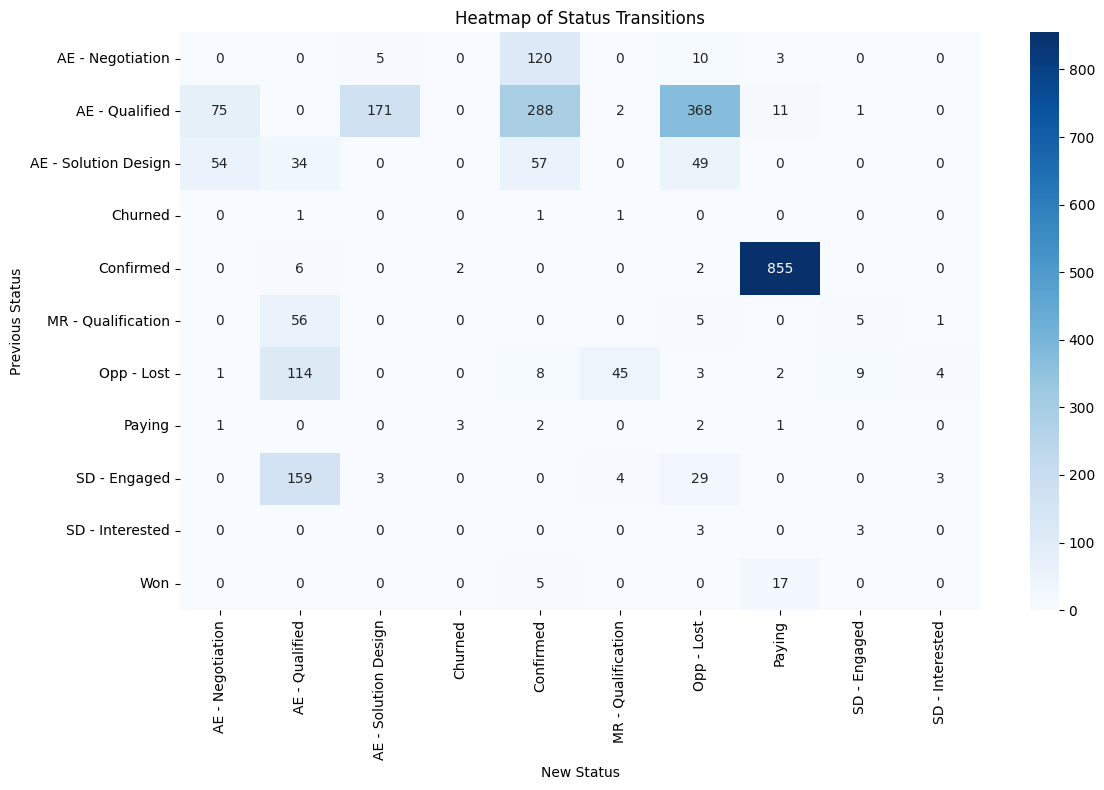

In [216]:
# Calculate old and new status transitions
df_transitions = df.sort_values(by=["company", "status_change_date"]).copy()
df_transitions["prev_status_label"] = df_transitions.groupby("company")["new_status_label"].shift(1)

# Drop rows where there's no previous status
transition_df = df_transitions.dropna(subset=["prev_status_label"])

# Create transition pairs
transition_matrix = (
    transition_df.groupby(["prev_status_label", "new_status_label"])
    .size()
    .reset_index(name="count")
)

# Pivot into a matrix form for heatmap
heatmap_data = transition_matrix.pivot(index="prev_status_label", columns="new_status_label", values="count").fillna(0)

# Heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues")
plt.title("Heatmap of Status Transitions")
plt.xlabel("New Status")
plt.ylabel("Previous Status")
plt.tight_layout()
plt.show()

This chart is a heatmap of status transitions, which helps us understand how leads move between different stages.

Some insights:


*   There is a high transition from confirmed to paying which indicates a healthy sales pipelines
*   There's a lot of time being spent in the "qualified" status, showing that clients are being requalified or re-evaluated which suggests that there might not be a firm qualification criteria on what qualifiess someone to progress forward in the funnel.
*   We're losing a lot of leads mid-funnel
*   Some leads are returning after being lost (Opp - Lost to AE - Qualified) which suggests there are re-engagement opportunitires
*   We continue to see that won is a rarely used status.








In [217]:
# Focus on 'Paying' rows with complete timestamps
conversion_df = df[df["new_status_label"] == "Paying"].copy()
conversion_df["conversion_days"] = (conversion_df["status_change_date"] - conversion_df["lead_created_date"]).dt.days

# Drop rows with missing opportunity_value or conversion_days
conversion_df = conversion_df.dropna(subset=["opportunity_value", "conversion_days"])

# Scatter plot with trend line
fig_corr = px.scatter(
    conversion_df,
    x="conversion_days",
    y="opportunity_value",
    trendline="ols",
    title="Correlation Between Deal Size and Conversion Speed",
    labels={"conversion_days": "Days to Convert", "opportunity_value": "Opportunity Value"}
)
fig_corr.show()

Lastly, we want to explore the relationship between deal size and conversion speed to try and answer if large deals take longer to close.

Some insights:
*   There's a slight positive correlation since the regression line trends slightly upward, but the relationshp isn't visually very strong.
*   Large deals exist during all days, but are more common after 100 days.
*   There's not a strong visual correlation overall.

## Predictive Scoring Approach and Logistic Regression Model

Predictive scoring in sales is crucial for prioritizing leads and opportunities. By assigning a score to each opportunity, sales teams can focus their efforts on those with the highest probability of conversion, optimizing resource allocation and improving overall sales efficiency. We will build a simple Logistic Regression model to predict whether an opportunity will become a 'Paying' customer.

We need to prepare our data by creating a target variable and selecting relevant features. The target variable will be `is_paying_customer` as 1 if `new_status_label` is 'Paying', otherwise it will be 0.

In [218]:
# Prepare the dataset
df_sales_model = df.copy()

In [219]:
# Feature Engineering
df_sales_model["is_paying_customer"] = (df_sales_model["new_status_label"] == "Paying").astype(int)

In [220]:
# Calculate time in process as a feature
df_sales_model["time_in_process"] = (df_sales_model["status_change_date"] - df_sales_model["lead_created_date"]).dt.days

In [221]:
# Drop rows with missing required values
df_sales_model = df_sales_model.dropna(subset=["time_in_process", "opportunity_value"])

In [222]:
# Select features
features = ["opportunity_value", "time_in_process"]
X = df_sales_model[features]
y = df_sales_model["is_paying_customer"]

In [223]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [224]:
# Train logistic regression model
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [225]:
# Perform cross-validation using ROC AUC as metric
cv_scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f}")

Cross-Validated ROC AUC Scores: [0.72292132 0.66424997 0.68885227 0.67206516 0.68032666 0.67787568
 0.68178132 0.69280258 0.62889425 0.58462786]
Mean AUC: 0.6694


In [226]:
# Store predicted probabilities
df_sales_model["lead_score"] = model.predict_proba(X)[:, 1]

In [227]:
df_sales_model.head()

,company,opportunity_value,old_status_label,new_status_label,status_change_date,lead_created_date,current_lead_status,current_lead_status_date,current_opp_status,current_opp_status_date,billing_period_unit,billing_period,lead_to_status_days,is_paying_customer,time_in_process,lead_score
0,company11,29,MR - Qualification,AE - Qualified,2018-10-08 15:33:40,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1,0,0,0,0.235857
1,company11,29,AE - Qualified,AE - Negotiation,2018-10-08 15:59:09,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1,0,0,0,0.235857
2,company11,29,AE - Negotiation,Confirmed,2018-10-10 14:47:37,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1,2,0,2,0.236641
3,company11,29,Confirmed,Paying,2018-10-18 12:25:32,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,3,10,1,10,0.239799
4,company15,272,MR - Qualification,AE - Qualified,2019-04-03 12:59:46,2019-04-01 09:54:41,Qualified,2019-04-03 12:57:49,AE - Qualified,2019-04-03 12:59:46,year,1,2,0,2,0.058529


## Data Visualization

We've used a simple Logistic Regression model in order to begin modeling the impact. Let's take a look at what this could tell us

In [228]:
fig5 = px.histogram(
    df_sales_model,
    x="lead_score",
    nbins=30,
    title="Lead Score Distribution",
    labels={"lead_score": "Predicted Lead Score (Probability of Conversion)"}
)
fig5.update_layout(yaxis_title="Number of Leads")
fig5.show()

This chart shows how likely each lead is to become a paying customer based on our Logistic Regression model:


*   Most probabilities cluster between 0.1 and 0.3 which means most leads are unlikely to convert, based on the model.
*   There's a small group on the far right that shows there's a smaller group that is likely to convert.
*   A lack of middle shows that there might be 1-2 features that are heavily driving predictions or that the features selected included are too close to the label.

We could explore this further by using a different model or auditing the features, which is outside the scope of this analysis.



In [229]:
# Potential Revenue from Top Leads
df_sales_model["simulated_revenue"] = df_sales_model["lead_score"] * df_sales_model["opportunity_value"]
top_leads = df_sales_model.sort_values(by="lead_score", ascending=False).head(10)

fig6 = px.bar(
    top_leads, x="company", y="simulated_revenue",
    title="Potential Revenue from Top 10 Scored Leads",
    labels={"simulated_revenue": "Expected Revenue", "company": "Company"},
)
fig6.update_layout(xaxis_tickangle=-45)
fig6.show()

This chart shows the expected revenue per company based on their predicted lead score and opportunity value, with each stack representing multiple opportunities per company.

We would be able to use this chart to prioritize targeting to top-priority accounts, based on a high predicted probability and high value. High lead score can boost the expected revenue even when deal size is low.



In [230]:
# Threshold Plot
precisions, recalls, thresholds = precision_recall_curve(y, df_sales_model["lead_score"])
f7_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # avoid division by zero

fig7 = go.Figure()
fig7.add_trace(go.Scatter(x=thresholds, y=precisions[:-1], mode='lines', name='Precision'))
fig7.add_trace(go.Scatter(x=thresholds, y=recalls[:-1], mode='lines', name='Recall'))
fig7.add_trace(go.Scatter(x=thresholds, y=f1_scores[:-1], mode='lines', name='F1 Score'))
fig7.update_layout(
    title="Classification Threshold Plot",
    xaxis_title="Threshold",
    yaxis_title="Score",
    legend_title="Metric"
)
fig7.show()

This graph shows how precision, recall, and F1 change across different probability thresholds when predicting whether a lead will convert or not.

*   Precision shows us the predicted positives that are actually correct
*   Recall shows us the actual positives that are successfully predicted
*   F1 score shows us what the balance is between both

We can estimate financial impact from here.


In [231]:
# Set current threshold
current_threshold = 0.24

# Predict outcomes based on threshold
df_sales_model["predicted_paying"] = (df_sales_model["lead_score"] >= current_threshold).astype(int)

# Filter predicted paying leads
predicted_leads = df_sales_model[df_sales_model["predicted_paying"] == 1]

predicted_leads["expected_revenue"] = predicted_leads["lead_score"] * predicted_leads["opportunity_value"]

total_expected_revenue = predicted_leads["expected_revenue"].sum()
avg_opportunity_value = predicted_leads["opportunity_value"].mean()

print(f" Total Leads Predicted to Convert: {len(predicted_leads)}")
print(f" Simulated Expected Revenue @ Threshold {current_threshold}: ${total_expected_revenue:,.2f}")
print(f" Average Deal Size: ${avg_opportunity_value:,.2f}")

 Total Leads Predicted to Convert: 1114
 Simulated Expected Revenue @ Threshold 0.24: $13,999.85
 Average Deal Size: $43.87


/tmp/ipython-input-231-3737225074.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [232]:
print(f"At threshold {current_threshold}, we expect to generate ${total_expected_revenue:,.2f} by pursuing {len(predicted_leads)} leads.")

At threshold 0.24, we expect to generate $13,999.85 by pursuing 1114 leads.


In [233]:
# Define thresholds to evaluate
thresholds = np.arange(0.0, 1.01, 0.01)

# Prepare lists to store results
precision_list = []
revenue_list = []
count_list = []

In [234]:
# Simulate revenue and precision at each threshold
for t in thresholds:
    df_sales_model["predicted_conversion"] = (df_sales_model["lead_score"] >= t).astype(int)
    precision = precision_score(df_sales_model["is_paying_customer"], df_sales_model["predicted_conversion"], zero_division=0)
    predicted_revenue = df_sales_model.loc[df_sales_model["predicted_conversion"] == 1, "lead_score"] * df_sales_model.loc[df_sales_model["predicted_conversion"] == 1, "opportunity_value"]

    precision_list.append(precision)
    revenue_list.append(predicted_revenue.sum())
    count_list.append(len(predicted_revenue))

In [235]:
# Plotly figure with dual y-axes
fig8 = go.Figure()
fig8.add_trace(go.Scatter(x=thresholds, y=precision_list, mode='lines+markers', name='Precision'))
fig8.add_trace(go.Scatter(x=thresholds, y=revenue_list, mode='lines+markers', name='Expected Revenue', yaxis='y2'))

fig8.update_layout(
    title="Trade-offs Between Precision and Revenue Across Thresholds",
    xaxis=dict(title='Threshold'),
    yaxis=dict(title='Precision', side='left'),
    yaxis2=dict(title='Expected Revenue', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99)
)

fig8.show()

As our model stands, we see that:

*   Precision increases since we're only choosing leads with higher conversion probability. We're excluding more leads which could lead to reduced revenue
*   Expected revenue decreases as the threshold rises. When the threshold is low, there may be leads that are false positives that could lead to higher revenue due to volume.
*   0.2 - 0.3 offers the best trade-off between precision and revenue.
*   Anything beyond 0.5 drops so much that revenue becomes negligible.


This chart helps us determine how selective we should be when pursuing leads to maximize ROI, given the data provided and the simple Logisitic Model.


*   If we have a sales team with a small capacity, a higher threshold improves their efficiency
*   If our priority is purely revenue growth, a lower threshold gives us a large pool of leads.





## Dashboard

I have included a rough mockup of the dashboard. In a dedicated visualization tool, there would be other ways to make the dashboard more visually appealing, like using drill-down options to observe certain months/years more clearly or add singular number to represent KPI's like the average time per company to become a customer.

In [236]:
from plotly.subplots import make_subplots

# Create subplot (3 rows, 2 columns)
fig_combined = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Expected Monthly Recurring Revenue (MRR) Over Time",
        "Sales Funnel Progression",
        "Monthly Churn vs Reactivation Trends",
        "Lead Score Distribution",
        "Cumulative Potential Customers per Month",
        ""  # Leave empty slot for sizing
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Add MRR Trend
for trace in fig3.data:
    fig_combined.add_trace(trace, row=1, col=1)
fig_combined.update_xaxes(title_text="Month", row=1, col=1)
fig_combined.update_yaxes(title_text="Expected MRR (USD)", row=1, col=1)

# Add Funnel
for trace in fig_funnel.data:
    fig_combined.add_trace(trace, row=1, col=2)

# Add Churn vs Reactivation
for trace in fig2.data:
    fig_combined.add_trace(trace, row=2, col=1)
fig_combined.update_xaxes(title_text="Month", row=2, col=1)
fig_combined.update_yaxes(title_text="Number of Customers", row=2, col=1)

# Add Conversion Probability
for trace in fig5.data:
    fig_combined.add_trace(trace, row=2, col=2)
fig_combined.update_xaxes(title_text="Predicted Lead Score", row=2, col=2)
fig_combined.update_yaxes(title_text="Number of Leads", row=2, col=2)

# Add Cumulative Potential Customers
for trace in fig4.data:
    fig_combined.add_trace(trace, row=3, col=1)
fig_combined.update_xaxes(title_text="Month", row=3, col=1)
fig_combined.update_yaxes(title_text="Cumulative Potential Customers", row=3, col=1)

# Final layout adjustments
fig_combined.update_layout(
    height=1200,
    width=1150,
    title_text="Liferay Sales Insights Dashboard",
    showlegend=False
)

fig_combined.show()


## Conclusion

Our analysis aimed to understand sales performance and drive revenue growth by better understanding Liferay's sales opportunity data. We gained insight into the average time it takes for a company to become a customer which is important for sales forecasting and identifying process bottlenecks. We quantified customer churn and reactivation which provide key metrics for understanding retention strategies and customer lifetime value. We calculated the MRR to have a better view of the company's financial health and the impact of sales and marketing efforts. We tracked the number of potential customers per month to provide insight to the health of our sales pipeline, lead generation, and potential future revenue. Lastly, our predictive scoring model, built using Logistic Regression, provides another opportunity to provide business value by assessing the likelihood of an opportunity converting to a paid customer. With additional feature selection and model refinement, predictive scoring models can help teams prioritize leads and improve forecasting accuracy. With these insights, Liferay is better suited to make decisions and create strategies around more efficient and profitable sales organization for future growth.